In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
plt.rc('font', family='Times New Roman')
start_time = timer()

from datetime import datetime

start_time = datetime.now()

# Feature Selection

In [77]:
# set some parameters
num_files = 1
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

In [78]:
final = pd.read_csv('final_vars.csv', index_col=0)

/Users/yduanmu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
final['zip5'] = final['zip5'].astype(str)

## Filter score

In [83]:
%%time
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
for i in range(num_files):
    df = final
    df = df[
        df['date'] <
        '2006-11-01']  # remove the last two months as the out-of-time data (OOT)
    df = df[
        df['date'] >
        '2006-01-14']  # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(
        len(df)
    )  # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df  # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns) - 2
    if (balance != 0):
        if (i == 0):
            num_goods_desired = int(min(num_goods, num_bads * balance))
            goods = goods.sample(n=num_goods_desired, random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()

        if (i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[
                goods_keep]  # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT

    df_sampled = pd.concat([goods, bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if (i == 0):  # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars + 1, 2)))
        filter_score.columns = ['variable', 'score']
        j = 0
        for column in df_sampled:
            filter_score.loc[j, 'variable'] = column
            filter_score.loc[j,
                             'score'] = sps.ks_2samp(goods[column],
                                                     bads[column])[0]
            j = j + 1

        filter_score.sort_values(by=['score'], ascending=False, inplace=True)

        vars_keep = list(filter_score['variable'][1:num_filter + 1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)

    if (i > 0):  # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars + 1, 2)))
        new.columns = ['variable', 'score']
        j = 0
        for column in df_sampled:
            new.loc[j, 'variable'] = column
            new.loc[j, 'score'] = sps.ks_2samp(goods[column], bads[column])[0]
            j = j + 1

        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter + 1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top, data_new_top], axis=1)
        filter_score = pd.concat([filter_score, new])

    del goods  # delete these before starting the next file, if any
    del bads
    gc.collect()

                                          variable     score
7                                            Fraud  1.000000
501             cardnum_state_zip5_country_total_7  0.685395
556               cardnum_merchnum_country_total_7  0.681689
391                       cardnum_merchnum_total_7  0.681463
492             cardnum_state_zip5_country_total_3  0.678065
..                                             ...       ...
626             cardnum_description_country_avg_30  0.597675
142                       state_zip5_country_max_0  0.597652
261                      description_country_max_1  0.597645
921  merchnum_description_state_zip5_country_max_1  0.597628
701                     merchnum_description_max_1  0.597553

[100 rows x 2 columns]
CPU times: user 15.5 s, sys: 2.17 s, total: 17.7 s
Wall time: 17.9 s


In [84]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter + 3])
print(i, ' vars_keep:', vars_keep)

0  vars_keep: ['cardnum_state_zip5_country_total_7', 'cardnum_merchnum_country_total_7', 'cardnum_merchnum_total_7', 'cardnum_state_zip5_country_total_3', 'cardnum_merchnum_country_total_14', 'cardnum_merchnum_total_14', 'cardnum_merchnum_country_total_3', 'cardnum_merchnum_total_3', 'cardnum_state_zip5_country_total_14', 'cardnum_description_country_total_7', 'cardnum_description_state_zip5_country_total_7', 'cardnum_description_country_total_14', 'cardnum_description_country_total_3', 'cardnum_description_state_zip5_country_total_14', 'cardnum_state_zip5_country_total_1', 'cardnum_merchnum_country_total_30', 'cardnum_description_country_max_14', 'cardnum_merchnum_total_30', 'cardnum_merchnum_country_total_1', 'cardnum_merchnum_total_1', 'cardnum_description_state_zip5_country_total_3', 'cardnum_description_country_max_7', 'cardnum_description_country_total_30', 'cardnum_state_zip5_country_max_14', 'cardnum_description_state_zip5_country_max_14', 'cardnum_state_zip5_country_max_7', 'c

In [85]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,cardnum_state_zip5_country_total_7,cardnum_merchnum_country_total_7,cardnum_merchnum_total_7,cardnum_state_zip5_country_total_3,cardnum_merchnum_country_total_14,cardnum_merchnum_total_14,cardnum_merchnum_country_total_3,cardnum_merchnum_total_3,cardnum_state_zip5_country_total_14,cardnum_description_country_total_7,...,cardnum_total_7,merchnum_total_3,cardnum_state_zip5_country_avg_30,description_state_zip5_country_max_1,cardnum_description_country_avg_30,state_zip5_country_max_0,description_country_max_1,merchnum_description_state_zip5_country_max_1,merchnum_description_country_max_1,merchnum_description_max_1
recnum,,,,,,,,,,,,,,,,,,,,,
3345,1960.27,1960.27,1960.27,333.47,1960.27,1960.27,333.47,333.47,1960.27,1960.27,...,3591.53,854.06,653.423333,333.47,653.423333,333.47,333.47,333.47,333.47,333.47
3346,341.23,324.43,324.43,178.41,499.22,499.22,165.41,165.41,530.02,21.17,...,997.73,740.84,4.491695,4.37,7.056667,4.37,4.37,4.37,4.37,4.37
3347,582.94,582.94,582.94,582.94,2306.98,2306.98,582.94,582.94,2306.98,582.94,...,9674.14,582.94,256.331111,278.73,256.331111,271.93,278.73,278.73,278.73,278.73
3348,344.85,328.05,328.05,182.03,502.84,502.84,169.03,169.03,533.64,24.79,...,1001.35,744.46,4.484370,4.37,6.197500,4.37,4.37,4.37,4.37,4.37
3349,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,...,16.28,130.15,16.280000,16.28,16.280000,16.28,16.28,16.28,16.28,16.28


In [86]:
Y = Y.values
X = df_keep

In [87]:
print(X.shape, Y.shape)

(80632, 100) (80632, 1)


In [88]:
def fdr(classifier, x, y, cutoff=detect_rate):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    # get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)


def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(
            y_prob.shape
    ) != 1:  # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:,
                        -1:]  # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])  # count the total nunber of frauds
    # sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(
        sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
    # return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud

## Wrapper (Top 30 variables)

In [89]:
%%time
from lightgbm import LGBMClassifier
# If you're doing forward selection it's enough to stop at num_wrapper variables.
# If you're doing backward selection you need to go through all the variables to get
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = LGBMClassifier(n_estimators=5,
                     n_jobs=-1)  # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,
          k_features=num_wrapper,
          forward=True,
          verbose=2,
          scoring=fdr,
          cv=2,
          n_jobs=-1)  # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished

[2022-04-23 01:30:19] Features: 1/30 -- score: 0.6370967741935484[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    8.0s finished

[2022-04-23 01:30:27] Features: 2/30 -- score: 0.6601382488479263[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    9.3s finished

[2022-04-23 01:30:37] Features: 3/30 -- score: 0.6705069124423964[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  97 o

CPU times: user 30 s, sys: 27 s, total: 57 s
Wall time: 5min 18s


[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   11.2s finished

[2022-04-23 01:35:25] Features: 30/30 -- score: 0.7223502304147466

SequentialFeatureSelector(cv=2, estimator=LGBMClassifier(n_estimators=5),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x7f7d4a65e3a0>, verbose=2)

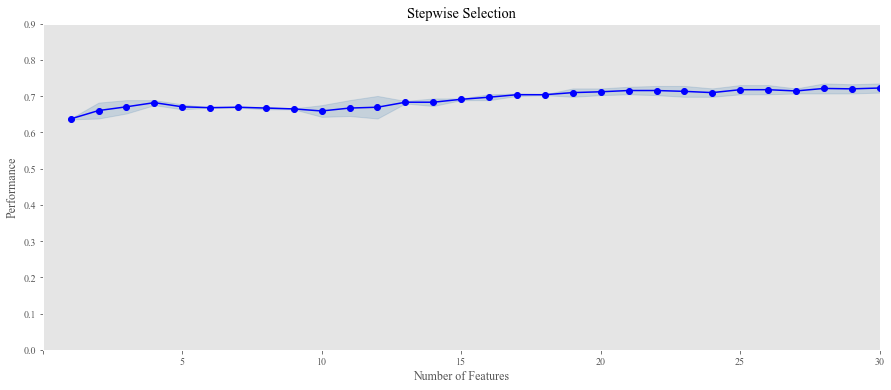

In [90]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .9])
plt.xlim(0, num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [91]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.6382488479262672, 0.6359447004608295]",0.637097,"(cardnum_description_country_total_3,)",0.004957,0.001152,0.001152
2,"(12, 21)","[0.6382488479262672, 0.6820276497695853]",0.660138,"(cardnum_description_country_total_3, cardnum_...",0.094182,0.021889,0.021889
3,"(12, 21, 25)","[0.652073732718894, 0.6889400921658986]",0.670507,"(cardnum_description_country_total_3, cardnum_...",0.079312,0.018433,0.018433
4,"(12, 21, 25, 30)","[0.6751152073732719, 0.6889400921658986]",0.682028,"(cardnum_description_country_total_3, cardnum_...",0.029742,0.006912,0.006912
5,"(12, 21, 25, 30, 34)","[0.663594470046083, 0.6774193548387096]",0.670507,"(cardnum_description_country_total_3, cardnum_...",0.029742,0.006912,0.006912
6,"(12, 21, 25, 30, 34, 40)","[0.6682027649769585, 0.6682027649769585]",0.668203,"(cardnum_description_country_total_3, cardnum_...",0.0,0.0,0.0
7,"(12, 21, 25, 30, 31, 34, 40)","[0.6682027649769585, 0.6705069124423964]",0.669355,"(cardnum_description_country_total_3, cardnum_...",0.004957,0.001152,0.001152
8,"(12, 21, 25, 30, 31, 34, 37, 40)","[0.663594470046083, 0.6705069124423964]",0.667051,"(cardnum_description_country_total_3, cardnum_...",0.014871,0.003456,0.003456
9,"(12, 20, 21, 25, 30, 31, 34, 37, 40)","[0.663594470046083, 0.6658986175115207]",0.664747,"(cardnum_description_country_total_3, cardnum_...",0.004957,0.001152,0.001152
10,"(12, 20, 21, 25, 30, 31, 32, 34, 37, 40)","[0.6428571428571429, 0.6751152073732719]",0.658986,"(cardnum_description_country_total_3, cardnum_...",0.069398,0.016129,0.016129


In [93]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['cardnum_state_zip5_country_total_7',
 'cardnum_merchnum_country_total_14',
 'cardnum_merchnum_total_14',
 'cardnum_description_country_total_14',
 'cardnum_description_country_total_3',
 'cardnum_description_state_zip5_country_total_14',
 'cardnum_merchnum_country_total_30',
 'cardnum_description_state_zip5_country_total_3',
 'cardnum_description_country_max_7',
 'cardnum_description_country_total_30',
 'cardnum_state_zip5_country_max_14',
 'cardnum_state_zip5_country_max_7',
 'cardnum_merchnum_max_14',
 'cardnum_description_country_max_30',
 'cardnum_description_state_zip5_country_max_7',
 'cardnum_description_state_zip5_country_total_30',
 'cardnum_description_state_zip5_country_max_30',
 'cardnum_merchnum_country_max_7',
 'cardnum_merchnum_max_7',
 'cardnum_merchnum_country_max_30',
 'cardnum_merchnum_max_30',
 'cardnum_description_country_max_3',
 'cardnum_state_zip5_country_max_3',
 'cardnum_description_state_zip5_country_max_3',
 'cardnum_merchnum_country_max_3',
 'description_

In [94]:
vars_final.sort()

In [95]:
vars_final

['cardnum_country_total_3',
 'cardnum_description_country_max_3',
 'cardnum_description_country_max_30',
 'cardnum_description_country_max_7',
 'cardnum_description_country_total_14',
 'cardnum_description_country_total_3',
 'cardnum_description_country_total_30',
 'cardnum_description_state_zip5_country_max_3',
 'cardnum_description_state_zip5_country_max_30',
 'cardnum_description_state_zip5_country_max_7',
 'cardnum_description_state_zip5_country_total_14',
 'cardnum_description_state_zip5_country_total_3',
 'cardnum_description_state_zip5_country_total_30',
 'cardnum_merchnum_country_max_3',
 'cardnum_merchnum_country_max_30',
 'cardnum_merchnum_country_max_7',
 'cardnum_merchnum_country_total_14',
 'cardnum_merchnum_country_total_30',
 'cardnum_merchnum_max_14',
 'cardnum_merchnum_max_30',
 'cardnum_merchnum_max_7',
 'cardnum_merchnum_total_14',
 'cardnum_state_zip5_country_max_14',
 'cardnum_state_zip5_country_max_3',
 'cardnum_state_zip5_country_max_7',
 'cardnum_state_zip5_coun

## Logic of Final 6 Variables Selection

- First, we split the top 30 variables into 2 sets. One of them includes the top 20 variables and another one includes the rest 10 variables. Then we ran the boosting models to compare the performance of these 2 sets of variables. Finally, we find the models based on the set with 10 variables performed better with fewer variables. So we decided to study on these 10 variables. 
- Then, we checked and removed the duplicates variables with a similar form in these 10 variables. Because we think there might be multicollinearity in the variables in the same form but with different time interval. So we removed two variables in this step. `Because we only recorded each experiment in excel, so we can only provide the final graph.`


In [110]:
%%html
# Remove duplicates
<img src='remove_duplicates.png', width=1000, height=500>

- Next, we focused on cardnum_state_zip5_country_max_3 this variable. Because after running models for so many times, the importance of this variable is not stable. Sometimes its importance is high and sometimes not. We believe this variable should be important but we think the time interval might be improper. So we checked the importance of these kind of variables with different time interval and change the time interval to 30. `Because we only recorded each experiment in excel as well, so we can only provide the final graph.`

In [109]:
%%html
# Time interval
<img src='change_time_interval.png', width=1000, height=500>

- Final step is to use SHapley Additive exPlanations (SHAP) algorithm to find relatively weaker variables. SHAP algorithm is an advanced explanation algorithm of boosting tree models. It can help us recognize relatively weaker variables with artificially high importance. From this graph, we can see that, for the 2 variables highlighted in the red box, their scatters are nearly all blue no matter the shap value is high or low. This means, the low value of these variables can have positive impact or negative impact or even no impact on the model output. However, the other variables have obvious impact on the model output when their value changes. So we removed these two variables and got our final 6 variables. 

**Note**: `The results of SHAP value summary plot are different every time due to different results of the catboost models. But the following graph is the most frequent and most representative one.`

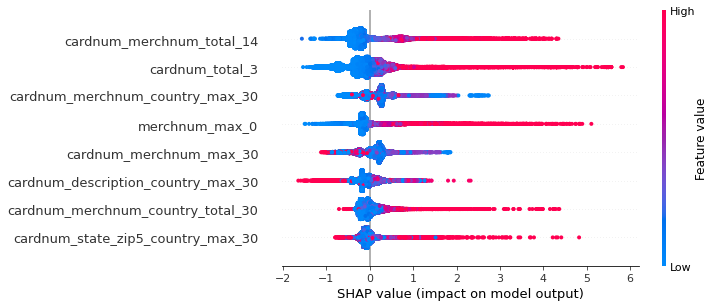

In [231]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

**`In this step, we didn't use dependence plot because the results of summary plot is obvious. But we think it will be really useful for other projects. Although the decisions we made are not based on dependence plots, we checked the dependence plots.`**

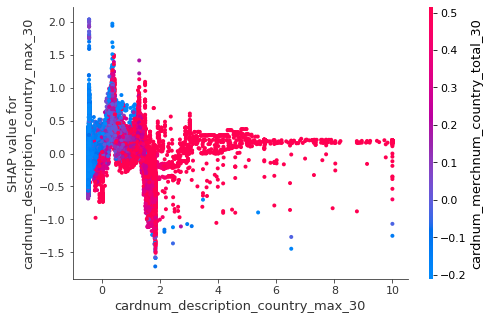

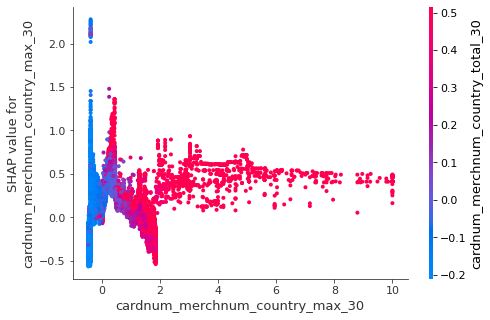

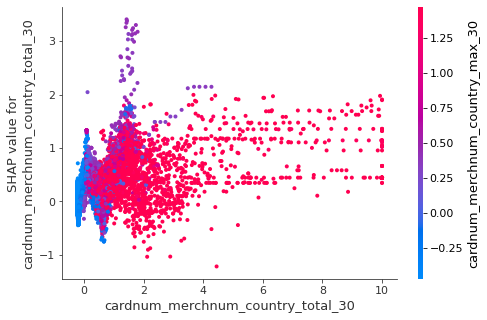

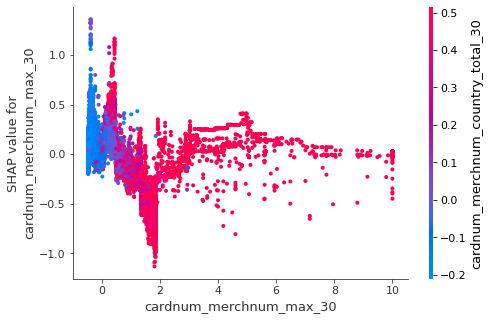

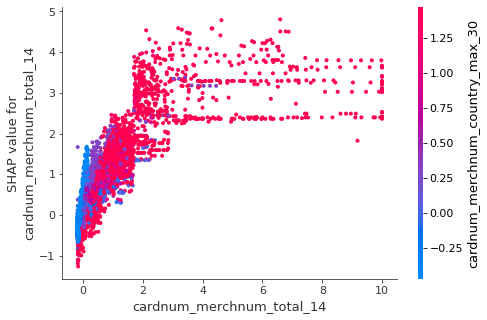

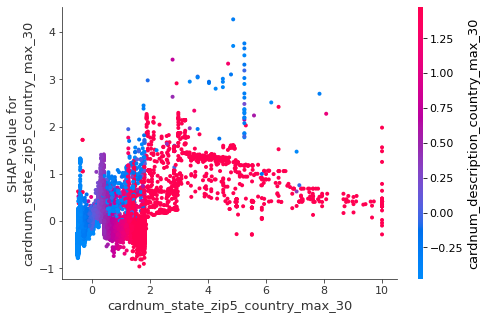

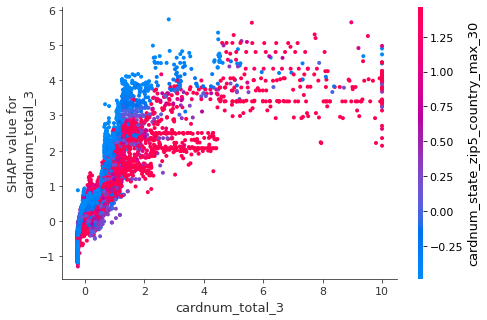

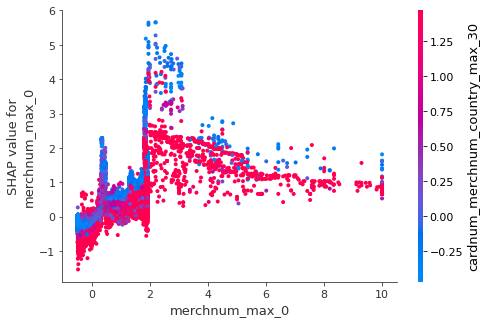

In [28]:
# Dependence plot
for i in X.columns:
    shap.dependence_plot(i, shap_values, X)

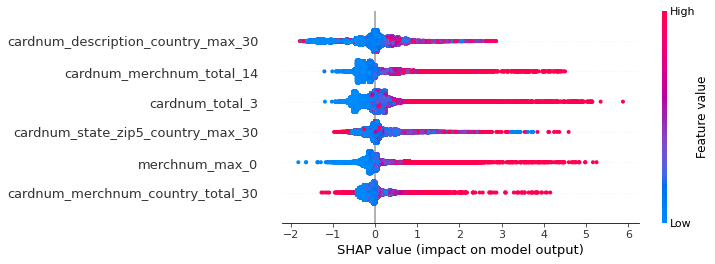

In [144]:
# SHAP Value summary plot of Final 6 variables
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

# Model Exploration

In [20]:
from datetime import datetime

start_time = datetime.now()

# Libraries to load
# !pip install lightgbm

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import catboost as cat
import lightgbm as lgb
import numpy as np
%matplotlib inline

print('LOAD DURATION: ',
      datetime.now() - start_time)  # load time about 30 seconds

LOAD DURATION:  0:00:00.322569


In [ ]:
# final_vars_list = ['cardnum_description_country_max_30','cardnum_merchnum_country_total_30','cardnum_merchnum_total_14','cardnum_state_zip5_country_max_30' ,'cardnum_total_3','merchnum_max_0','recnum','Fraud']

# final_6vars = final.filter(final_vars_list,axis =1)

# final_6vars.to_csv('6vars.csv')

In [2]:
vars = pd.read_csv('6vars.csv')
vars.head()

,Fraud,cardnum_state_zip5_country_max_30,cardnum_description_country_max_30,cardnum_merchnum_country_total_30,cardnum_merchnum_total_14,cardnum_total_3,merchnum_max_0,recnum
0,0,3.62,3.62,3.62,3.62,3.62,3.62,1
1,0,31.42,31.42,31.42,31.42,31.42,31.42,2
2,0,178.49,178.49,178.49,178.49,178.49,178.49,3
3,0,3.62,3.62,3.62,3.62,3.62,3.62,4
4,0,3.62,3.62,7.24,7.24,7.24,3.62,5


In [5]:
# use this to cap variables. For some problems it helps
Clip = 10

In [6]:
vars['Fraud'].sum()

1059

In [7]:
vars.shape

(96397, 8)

In [8]:
vars.describe()

,Fraud,cardnum_state_zip5_country_max_30,cardnum_description_country_max_30,cardnum_merchnum_country_total_30,cardnum_merchnum_total_14,cardnum_total_3,merchnum_max_0,recnum
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,0.010986,533.052596,514.938096,925.026954,772.109278,1512.932952,513.822163,48365.481820
std,0.104236,1085.938041,1074.891915,4303.734662,4170.644835,6115.505329,1035.024182,27945.003883
min,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1.000000
25%,0.000000,59.060000,49.180000,93.920000,77.160000,140.000000,56.750000,24154.000000
50%,0.000000,215.000000,200.780000,290.000000,237.750000,518.610000,196.000000,48365.000000
75%,0.000000,618.730000,595.000000,825.320000,679.670000,1550.000000,591.660000,72578.000000
max,1.000000,47900.000000,47900.000000,306633.410000,306633.410000,310843.060000,47900.000000,96753.000000


In [9]:
record_save = vars['recnum']
Y_save = pd.DataFrame(vars.loc[:, 'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns=['recnum', 'Fraud'])
# X_no_scaling.describe()

In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# push in any outlier values
cols = X.columns
X.loc[:, cols] = X[cols].clip(upper=Clip)
X.loc[:, cols] = X[cols].clip(lower=-1 * Clip)
# X.describe()

In [14]:
X

,cardnum_state_zip5_country_max_30,cardnum_description_country_max_30,cardnum_merchnum_country_total_30,cardnum_merchnum_total_14,cardnum_total_3,merchnum_max_0
0,-0.487535,-0.475693,-0.214095,-0.184262,-0.246801,-0.492937
1,-0.461935,-0.449830,-0.207635,-0.177596,-0.242255,-0.466078
2,-0.326504,-0.313006,-0.173463,-0.142333,-0.218206,-0.323985
3,-0.487535,-0.475693,-0.214095,-0.184262,-0.246801,-0.492937
4,-0.487535,-0.475693,-0.213254,-0.183394,-0.246209,-0.492937
...,...,...,...,...,...,...
96392,-0.412788,-0.400178,-0.195234,-0.164799,-0.233528,-0.414514
96393,0.061511,0.078996,-0.047965,-0.012830,0.266097,-0.381703
96394,-0.156079,-0.140831,-0.130460,-0.097958,0.028941,1.907354
96395,1.536899,1.569546,0.423029,0.342854,0.112680,1.631081


In [15]:
# final[final['date'] == '2006-11-01']

In [16]:
# separate data into modeling (traintest) and out of time
X_trntst = X[0:83970]
Y_trntst = Y_save[0:83970]
X_oot = X[83970:]
Y_oot = Y_save[83970:]

In [17]:
niter = 0
nitermax = 10
FDR3 = pd.DataFrame(np.zeros((nitermax, 3)), columns=('trn', 'tst', 'oot'))
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

### Logistic Regression

In [ ]:
%%time
# Logistic regression

for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = LogisticRegression(penalty='l2', C=0.1, solver='saga')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

### Decision Tree

In [18]:
%%time
# Single DT

for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = DecisionTreeClassifier(criterion='entropy',
                                   max_depth=20,
                                   min_samples_leaf=60,
                                   splitter='random')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.6919354838709677 0.6192307692307693 0.3687150837988827
1 0.702922077922078 0.6628787878787878 0.4301675977653631
2 0.6887417218543046 0.6811594202898551 0.36312849162011174
3 0.7287581699346405 0.6902985074626866 0.4301675977653631
4 0.6971153846153846 0.69921875 0.43575418994413406
5 0.6688963210702341 0.6276595744680851 0.39664804469273746
6 0.6731707317073171 0.6830188679245283 0.33519553072625696
7 0.715 0.6857142857142857 0.3743016759776536
8 0.6912972085385879 0.7121771217712177 0.3128491620111732
9 0.6791530944625407 0.6616541353383458 0.4245810055865922
trn    0.693699
tst    0.672301
oot    0.387151
dtype: float64
CPU times: user 610 ms, sys: 34.9 ms, total: 645 ms
Wall time: 646 ms


### Random Forest

In [123]:
%%time
# RF

for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = RandomForestClassifier(bootstrap=True,
                                   n_estimators=20,
                                   max_depth=5,
                                   min_samples_leaf=15,
                                   criterion='gini',
                                   max_features='log2')
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.693200663349917 0.7111913357400722 0.5363128491620112
1 0.712241653418124 0.7171314741035857 0.6145251396648045
2 0.712 0.6784313725490196 0.553072625698324
3 0.7607655502392344 0.7233201581027668 0.5363128491620112
4 0.711755233494364 0.7258687258687259 0.5586592178770949
5 0.7193548387096774 0.676923076923077 0.5642458100558659
6 0.7119205298013245 0.7065217391304348 0.5810055865921788
7 0.7333333333333333 0.6792452830188679 0.553072625698324
8 0.7259380097879282 0.6891385767790262 0.5698324022346368
9 0.7172523961661342 0.6614173228346457 0.5195530726256983
trn    0.719776
tst    0.696919
oot    0.558659
dtype: float64
CPU times: user 8.02 s, sys: 62.5 ms, total: 8.08 s
Wall time: 8.08 s


### lightgbm

In [77]:
%%time

for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = lgb.LGBMClassifier(boosting_type='goss',
                               max_depth=-1,
                               num_leaves=10,
                               n_estimators=50,
                               colsample_bytree=0.5,
                               subsample=0.5,
                               learning_rate=0.001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.6802030456852792 0.7301038062283737 0.5754189944134078
1 0.7445008460236887 0.6885813148788927 0.5754189944134078
2 0.697452229299363 0.6587301587301587 0.547486033519553
3 0.7316666666666667 0.65 0.5865921787709497
4 0.6867862969004894 0.6928838951310862 0.5810055865921788
5 0.7207792207792207 0.6666666666666666 0.5865921787709497
6 0.7081967213114754 0.7037037037037037 0.5642458100558659
7 0.7114754098360656 0.7037037037037037 0.5195530726256983
8 0.7121951219512195 0.6943396226415094 0.5642458100558659
9 0.6945337620578779 0.6705426356589147 0.5810055865921788
trn    0.708779
tst    0.685926
oot    0.568156
dtype: float64
CPU times: user 11.4 s, sys: 1.3 s, total: 12.7 s
Wall time: 1.64 s


### XGBoost

In [813]:
%%time
# XGB
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = xgb.XGBClassifier(use_label_encoder=False,
                              max_depth=7,
                              n_estimators=1200,
                              min_child_weight=12,
                              colsample_bytree=0.8,
                              subsample=0.15,
                              eta=0.2,
                              tree_method='hist',
                              booster='gbtree',
                              scale_pos_weight=1,
                              reg_lambda=8,
                              reg_alpha=6,
                              nthread=8)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel(), eval_metric='logloss')

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.750814332247557 0.6954887218045113 0.5307262569832403
1 0.754071661237785 0.6992481203007519 0.49162011173184356
2 0.7364085667215815 0.7472527472527473 0.5251396648044693
3 0.765079365079365 0.724 0.49162011173184356
4 0.7317880794701986 0.75 0.5251396648044693
5 0.7372611464968153 0.7261904761904762 0.5027932960893855
6 0.7407407407407407 0.7027972027972028 0.5139664804469274
7 0.740924092409241 0.7299270072992701 0.5139664804469274
8 0.743801652892562 0.7236363636363636 0.5307262569832403
9 0.7610474631751227 0.7026022304832714 0.5139664804469274
trn    0.746194
tst    0.720114
oot    0.513966
dtype: float64
CPU times: user 2min 30s, sys: 1.88 s, total: 2min 32s
Wall time: 19.3 s


### CatBoost

In [630]:
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = cat.CatBoostClassifier(learning_rate=0.04,
                                   iterations=1000,
                                   loss_function='Logloss',
                                   depth=5,
                                   od_wait=300,
                                   od_type='Iter',
                                   random_state=3,
                                   l2_leaf_reg=0.1,
                                   scale_pos_weight=0.8,
                                   verbose=False)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0 0.8810289389067524 0.7906976744186046 0.553072625698324
1 0.8536585365853658 0.7962264150943397 0.6312849162011173
2 0.8877887788778878 0.7554744525547445 0.547486033519553
3 0.8702791461412152 0.7859778597785978 0.5977653631284916
4 0.8682432432432432 0.7916666666666666 0.6089385474860335
5 0.8726415094339622 0.8032786885245902 0.6256983240223464
6 0.8680781758957655 0.793233082706767 0.6089385474860335
7 0.8659305993690851 0.8130081300813008 0.6312849162011173
8 0.8687196110210696 0.7908745247148289 0.6145251396648045
9 0.8725490196078431 0.7761194029850746 0.5251396648044693
trn    0.844144
tst    0.780939
oot    0.613687
dtype: float64


### Neural Network

In [819]:
%%time
# NN

for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst,
                                                  Y_trntst,
                                                  test_size=.3)

    model = MLPClassifier(hidden_layer_sizes=30,
                          activation='relu',
                          solver='lbfgs',
                          alpha=0.15,
                          learning_rate='constant',
                          max_iter=300)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:, 1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0] * 0.03))
    temp = X_trn.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed) / sum(X_trn.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_tst)[:, 1]
    X_tst['predicted'] = predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0] * 0.03))
    temp = X_tst.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed) / sum(X_tst.loc[:, 'Fraud'])

    predictions = model.predict_proba(X_oot)[:, 1]
    X_oot['predicted'] = predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0] * 0.03))
    temp = X_oot.sort_values('predicted', ascending=False).head(topRows)
    needed = temp.loc[:, 'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed) / sum(X_oot.loc[:, 'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'], FDR3.loc[niter, 'tst'],
          FDR3.loc[niter, 'oot'])

print(FDR3.mean())

0 0.6948051948051948 0.6704545454545454 0.5921787709497207
1 0.6916802610114192 0.6629213483146067 0.5307262569832403
2 0.7142857142857143 0.6731517509727627 0.6201117318435754
3 0.697324414715719 0.6737588652482269 0.5698324022346368
4 0.7088815789473685 0.6875 0.6201117318435754
5 0.695859872611465 0.7420634920634921 0.5921787709497207
6 0.6915584415584416 0.696969696969697 0.5139664804469274
7 0.7321131447587355 0.6487455197132617 0.48044692737430167
8 0.7345575959933222 0.6619217081850534 0.5307262569832403
9 0.734920634920635 0.612 0.6256983240223464
trn    0.709599
tst    0.672949
oot    0.567598
dtype: float64
CPU times: user 13min 47s, sys: 4min 32s, total: 18min 20s
Wall time: 2min 23s


# Result

In [189]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [190]:
cols = [
    'bin', '#recs', '#g', '#b', '%g', '%b', 'tot', 'cg', 'cb', '%cg', 'FDR',
    'KS', 'FPR'
]
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns=cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns=cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns=cols)
trn_sorted = X_trn_eval.sort_values('predicted', ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted', ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted', ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,cardnum_description_country_max_30,cardnum_merchnum_country_total_30,cardnum_merchnum_total_14,cardnum_state_zip5_country_max_30,cardnum_total_3,merchnum_max_0,predicted,Fraud
89121,2.888608,6.665728,6.915104,2.842545,4.594815,1.531866,0.981925,1
89128,2.888608,6.774668,7.027520,2.842545,4.671481,1.531866,0.981925,1
89074,2.888608,4.813051,5.003306,2.842545,3.291010,3.000952,0.963573,1
89060,2.888608,3.390554,3.535415,2.842545,2.289939,3.000952,0.963573,1
89068,2.888608,4.123466,4.291715,2.842545,2.805720,3.000952,0.963573,1
89077,2.888608,5.048188,5.245947,2.842545,3.456486,3.000952,0.963573,1
89117,2.888608,6.202133,6.436715,2.842545,4.268564,1.531866,0.955921,1
89120,2.888608,6.284545,6.521757,2.842545,4.326561,1.531866,0.955921,1
89114,2.888608,6.106046,6.337562,2.842545,4.200944,1.531866,0.955921,1
89083,2.888608,5.182669,5.384719,2.842545,3.551126,-0.127274,0.939162,1


In [191]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0] * 0.01 * i))
    percent_rows_tst = int(round(X_tst_eval.shape[0] * 0.01 * i))
    percent_rows_oot = int(round(X_oot_eval.shape[0] * 0.01 * i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:, 'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:, 'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:, 'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot

    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i, '#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i - 1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i - 1, 'cb']
        FDR_trn.loc[i, '#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i,
                    '%g'] = 100 * (num_good_trn - FDR_trn.loc[i - 1, 'cg']) / (
                        num_tot_trn - FDR_trn.loc[i - 1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i - 1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i - 1, 'cb']
        FDR_tst.loc[i, '#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i,
                    '%g'] = 100 * (num_good_tst - FDR_tst.loc[i - 1, 'cg']) / (
                        num_tot_tst - FDR_tst.loc[i - 1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i - 1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i - 1, 'cb']
        FDR_oot.loc[i, '#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i,
                    '%g'] = 100 * (num_good_oot - FDR_oot.loc[i - 1, 'cg']) / (
                        num_tot_oot - FDR_oot.loc[i - 1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_trn

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,588.0,189.0,399.0,32.142857,67.857143,588.0,189.0,399.0,0.324921,65.302782,64.977861,0.473684
2,2.0,588.0,532.0,56.0,90.476190,9.523810,1176.0,721.0,455.0,1.239513,74.468085,73.228572,1.584615
3,3.0,587.0,560.0,27.0,95.400341,4.599659,1763.0,1281.0,482.0,2.202242,78.887070,76.684829,2.657676
4,4.0,588.0,573.0,15.0,97.448980,2.551020,2351.0,1854.0,497.0,3.187319,81.342062,78.154743,3.730382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,588.0,588.0,0.0,100.000000,0.000000,56428.0,55817.0,611.0,95.958259,100.000000,4.041741,91.353519
97,97.0,588.0,588.0,0.0,100.000000,0.000000,57016.0,56405.0,611.0,96.969124,100.000000,3.030876,92.315876
98,98.0,587.0,587.0,0.0,100.000000,0.000000,57603.0,56992.0,611.0,97.978270,100.000000,2.021730,93.276596
99,99.0,588.0,588.0,0.0,100.000000,0.000000,58191.0,57580.0,611.0,98.989135,100.000000,1.010865,94.238953


In [192]:
num_bads_trn = sum(X_trn_eval.loc[:, 'Fraud'])
num_goods_trn = X_trn_eval.shape[0] - num_bads_trn
X_trn_eval.shape[0], num_goods_trn, num_bads_trn

(58779, 58168, 611)

In [193]:
num_bads_tst = sum(X_tst_eval.loc[:, 'Fraud'])
num_goods_tst = X_tst_eval.shape[0] - num_bads_tst
X_tst_eval.shape[0], num_goods_tst, num_bads_tst

(25191, 24922, 269)

In [194]:
num_bads_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_goods_oot = X_oot_eval.shape[0] - num_bads_oot
X_oot_eval.shape[0], num_goods_oot, num_bads_oot

(12427, 12248, 179)

In [195]:
FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,43.0,81.0,34.677419,65.322581,124.0,43.0,81.0,0.351078,45.251397,44.900319,0.530864
2,2.0,125.0,105.0,20.0,84.000000,16.000000,249.0,148.0,101.0,1.208361,56.424581,55.216220,1.465347
3,3.0,124.0,110.0,14.0,88.709677,11.290323,373.0,258.0,115.0,2.106466,64.245810,62.139344,2.243478
4,4.0,124.0,119.0,5.0,95.967742,4.032258,497.0,377.0,120.0,3.078054,67.039106,63.961053,3.141667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,124.0,124.0,0.0,100.000000,0.000000,11930.0,11751.0,179.0,95.942195,100.000000,4.057805,65.648045
97,97.0,124.0,124.0,0.0,100.000000,0.000000,12054.0,11875.0,179.0,96.954605,100.000000,3.045395,66.340782
98,98.0,124.0,124.0,0.0,100.000000,0.000000,12178.0,11999.0,179.0,97.967015,100.000000,2.032985,67.033520
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12303.0,12124.0,179.0,98.987590,100.000000,1.012410,67.731844


In [196]:
FDR_oot_graph = FDR_oot.copy()
FDR_oot_graph['Fraud Savings'] = FDR_oot_graph['cb'] * 2000
FDR_oot_graph['Good Loss'] = FDR_oot_graph['cg'] * 50
FDR_oot_graph['Overall Savings'] = FDR_oot_graph[
    'Fraud Savings'] - FDR_oot_graph['Good Loss']

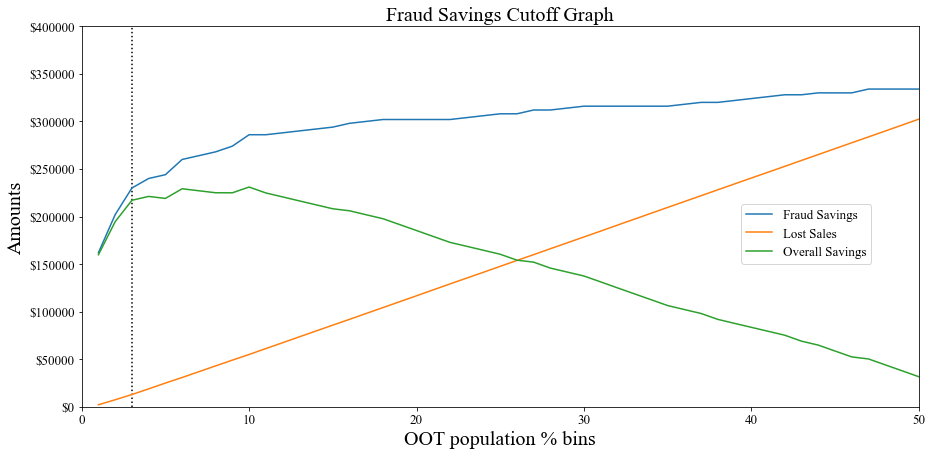

In [197]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 13})
plt.rc('font', family='Times New Roman')
plt.title('Fraud Savings Cutoff Graph', fontsize=20)
plt.ylim(0, 400000)
plt.xlim(0, 50)
plt.xlabel('OOT population % bins', fontsize=20)
plt.ylabel('Amounts', fontsize=20)
plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(FDR_oot_graph['bin'][1:101],
         FDR_oot_graph['Fraud Savings'][1:101],
         label="Fraud Savings")
plt.plot(FDR_oot_graph['bin'][1:101],
         FDR_oot_graph['Good Loss'][1:101],
         label="Lost Sales")
plt.plot(FDR_oot_graph['bin'][1:101],
         FDR_oot_graph['Overall Savings'][1:101],
         label="Overall Savings")
plt.vlines(3, 0, 400000, 'black', 'dotted')
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.legend(loc='upper left', bbox_to_anchor=(0.78, 0.55))
plt.rcParams["legend.loc"] = 'right'

**`The graph above is a line plot which shows the amount of gains with a coresspoding %declines of our total population.`**

**`We recommend a score cutoff at 3% since it can decline most of the frauds while maintaining a good satsifaction of customer experience.`**

In [198]:
FDR_oot_graph.head(10)

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR,Fraud Savings,Good Loss,Overall Savings
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1.0,124.0,43.0,81.0,34.677419,65.322581,124.0,43.0,81.0,0.351078,45.251397,44.900319,0.530864,162000.0,2150.0,159850.0
2,2.0,125.0,105.0,20.0,84.000000,16.000000,249.0,148.0,101.0,1.208361,56.424581,55.216220,1.465347,202000.0,7400.0,194600.0
3,3.0,124.0,110.0,14.0,88.709677,11.290323,373.0,258.0,115.0,2.106466,64.245810,62.139344,2.243478,230000.0,12900.0,217100.0
4,4.0,124.0,119.0,5.0,95.967742,4.032258,497.0,377.0,120.0,3.078054,67.039106,63.961053,3.141667,240000.0,18850.0,221150.0
5,5.0,124.0,122.0,2.0,98.387097,1.612903,621.0,499.0,122.0,4.074135,68.156425,64.082290,4.090164,244000.0,24950.0,219050.0
6,6.0,125.0,117.0,8.0,93.600000,6.400000,746.0,616.0,130.0,5.029393,72.625698,67.596306,4.738462,260000.0,30800.0,229200.0
7,7.0,124.0,122.0,2.0,98.387097,1.612903,870.0,738.0,132.0,6.025474,73.743017,67.717543,5.590909,264000.0,36900.0,227100.0
8,8.0,124.0,122.0,2.0,98.387097,1.612903,994.0,860.0,134.0,7.021555,74.860335,67.838781,6.417910,268000.0,43000.0,225000.0
9,9.0,124.0,121.0,3.0,97.580645,2.419355,1118.0,981.0,137.0,8.009471,76.536313,68.526842,7.160584,274000.0,49050.0,224950.0


In [199]:
FDR3.to_csv('FDR3_final.csv')

In [200]:
FDR_trn.to_csv('FDR_trn_final.csv', index=False)
FDR_tst.to_csv('FDR_tst_final.csv', index=False)
FDR_oot.to_csv('FDR_oot_final.csv', index=False)